## Climate Change Sentiment Analysis

## Table of contents

1. Climate Change Sentiment Analysis
    - Introduction 
    - Import library
2. Exploratory Data Analysis
3. Text Preprocessing
    - Noise Removal
    - Lexicon Normalization
4. Dealing with Class Imbalance
5. Feature Engineering on text data
6. Building Machine Learning Models
    - Logistic Regression Classifier
    - Random Forest Classifier
    - Decision Tree Classifier
    - Support Vector Classifier
7. Compare and choose the best model
8. Kaggle submission
7. Saving a model with Pickle

### Introduction

Climate change is a phenomenon that is caused by a long-term alteration of global or regional climate patterns due to human activities. Burning fossil fuels release greenhouse gases that trap the sun's heat and cause the planet's temperature to rise. This could be worse unless further action is taken. however, many companies and governments are on the quest to reduce the carbon footprint by improving on thier products. To do this organizations needs insights from the customers by analysing thier data.

Social media is one of the go to places for data mining. Twitter is the best platform with the topics related to climate change for data mining. Text analytics is a method of analysing unstructured data in order to find trends or predict popular sentiments, which can assist organisations in making decisions.

The goal of this project is to build a machine learning model to predict sentiment of tweets on twitter in order to determine how people perceive climate change and whether or not they believe it is a real threat.

### Import  libraries

In [1]:
# libraries for data manupulation

import numpy as np
import pandas as pd

# regular expression 
import re

# libraries for Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# from wordcloud import WordCloud

# Natural Language ToolKit (nltk) for data preprocessing.
import nltk
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer


# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('omw-1.4')

# libraries for building classification models
from sklearn import svm
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#libraries for model evaluation
import time
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

#library to save the model
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
# defining stopwords variable
stopwords = stopwords.words('english')

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
#load the data 
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_with_no_labels.csv')

## Exploratory Data Analysis

The first thing to do is exploring the dataset to discover the trends and patterns, and whether the dataset is a binary or multi-dimensional classification since the goal is to classify text into different categories or sentiments. This is also helpful for the pre-processing phase to determine what to remove as noise and what to keep.

In [5]:
# Get familiar with train data
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


The data has three columns `sentiment` (int64), `message` (object) and `tweetid` (int64). This is confirmed by running the cell bellow

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [7]:
train_df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

The data does not have missing values and has 15819 row with 3 columns

In [8]:
# Unique sentiments
unique_sentiment = list(train_df['sentiment'].unique())
unique_sentiment

[1, 2, 0, -1]

There are four unique sentiments in the sentiment column which are classified as follow:

 - $1:$ Pro - the tweet supports the belief of man-made climate cahnge 
 - $2:$ News - the tweet link to factual news about climate change
 - $0:$ Neutral - the tweet neither supports nor refuses the belief of man-made climate change 
 - $-1:$ Anti - the tweet does not believe in man-made climate change. 

In [9]:
# check the frequency of each sentiment in the dataset
train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

There is a large number of tweets about 8530 for sentiment $1$(Pro), that means there are more people supporting the man-made climate change followed by tweet that link to factual news (sentiment $2$). Below is the visualization of the sentiments using histogram.

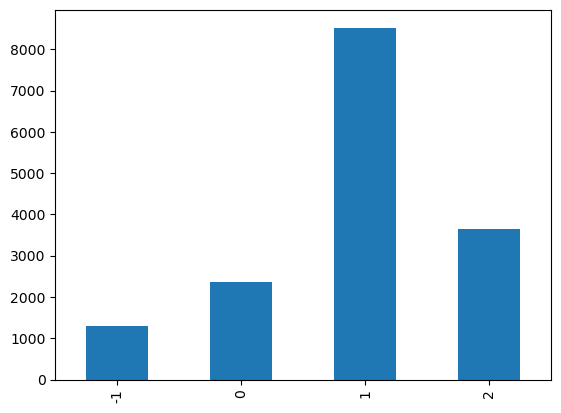

In [10]:
# The count of each sentiment on the data
train_df['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [11]:
test_df.shape

(10546, 2)

The distribution of the plot above is more skewed towards the positive side of the climate change sentiments and it also reveals what is called class imbalance, a problem that needs to be taken care of later before building a model. Class imbalance will results in high accuracy score for the Pro sentiment compared to other sentimemts which would result in a poor performing model as it would not predict well the tweets that do not fully support man-made climate change. 

# Text Preprocessing 
Looking again at the data but this time on the tweets column since text is one of the unstructured data and most of the times it includes various types of noise which makes the data not readily analyzable without any cleaning.

Data cleaning can be done in two steps:
 - Noise Removal (stopwords, URLs, punctuations & mentions etc)
 - Lexicon Normalization (Stemming & Lemmatization)

In [12]:
# Subset of the tweets from the data
for t in train_df['message'][27:30]:
    print(t)

Hey There! Michael's vetted and approved market-based strategies for tackling climate change are supported by a majority of Cdns! #cdnpoli
Sally Kohn’s latest evidence of climate change proves she is ‘not a smart person’ https://t.co/MhkzoGL9Vt via @twitchyteam Need we say more
RT @StarTalkRadio: First: The public understands climate change better than Congress. Why? #JohnHoldren @CoryBooker @neiltyson explain: htt…


### Noise Removal
The subset of the tweets above shows that there are URLs, punctuations, mentions, hashtags and stopwords etc that are not needed. The function bellow will remove all this noise.

In [13]:
def clean_text(text):
    
    """The funtion will at once remove URL's and replace with http followed by removing any mentions and hashtags,
    any number from the text and the retweets(RT) with extra spaces"""
    
    text = re.sub(r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+', r'http', text)
    text = re.sub(r"[@#][\w]*", '', text) # remove any mentions and hashtags
    text = re.sub(r'[^a-zA-Z]', ' ', text) # remove any number from the text
    text = re.sub(r'RT', '', text) # remove any RT
    text = re.sub(r'\s\s+', ' ', text) # remove extra spaces
    return text

In [14]:
# apply the function to the whole dataset
train_df['message'] = train_df['message'].apply(clean_text)

In [15]:
# cleaned subset of the tweets
for t in train_df['message'][27:30]:
    print(t)

Hey There Michael s vetted and approved market based strategies for tackling climate change are supported by a majority of Cdns 
Sally Kohn s latest evidence of climate change proves she is not a smart person http via Need we say more
 First The public understands climate change better than Congress Why explain htt 


All the noise is removed succesfully except for the stopwords which will be removed in the next step.

### Lexicon Normalization

In english there are many single words that differ in meaning but contextually all are simmilar. These word if not handled correctly can affect the perfomance of the ML model, hence it is important to convert disparities of a word into their normalized form also known as lemma. This way ML model would be improved as high dimensional features are reduced to low dimensional features.

Normalization is done through:
 - Stemming: stemming is a process of stripping the suffixes from a word.
 - Lemmatization: It is an organized and step by step procedure of obtaining the root form of the word.
 

Below is the code that will remove the stopwords and lemmatize and tokenize the text

In [16]:
def text_to_tokens(text):
    
    """This function tokenizes the text using TreeBankWordTokenizer and convert the tokens into lowercase, 
    lemmatize the text and removes stopwords"""
    
    # text to tokens
    tokenizer = TreebankWordTokenizer() # instantiate tokenizer object
    tokens = tokenizer.tokenize(text) # tokenize the text
    tokens_lower = [t.lower() for t in tokens] # converting all the tokens to lowercase
    
    # lemmatizing the text
    lemmatizer = WordNetLemmatizer() # instantiate lemmatizer object
    lemmatise = [lemmatizer.lemmatize(t) for t in tokens_lower] # lemmatize each word in the list of tokens
    useful_tokens = [t for t in lemmatise if t not in stopwords] # removes all the stopwords
    
    return useful_tokens

In [17]:
# apply the function to the whole dataset
train_df['message'] = train_df['message'].apply(text_to_tokens)

In [18]:
# converting tokens in each tweet into a sentance
train_df['message'] = train_df['message'].apply(lambda x: " ".join(x))

In [19]:
# cleaned train dataset
train_df['message'].head()

0    polyscimajor epa chief think carbon dioxide ma...
1      like lack evidence anthropogenic global warming
2    researcher say three year act climate change l...
3        wired wa pivotal year war climate change http
4    racist sexist climate change denying bigot lea...
Name: message, dtype: object

In [20]:
# Cleaning the test dataset
test_df['message'] = test_df['message'].apply(clean_text)
test_df['message'] = test_df['message'].apply(text_to_tokens)
test_df['message'] = test_df['message'].apply(lambda x: " ".join(x))

In [21]:
# cleaned test dataset
test_df.head()

,message,tweetid
0,europe looking china make sure alone fighting ...,169760
1,combine polling staffer climate change woman r...,35326
2,scary unimpeachable evidence climate change al...,224985
3,putin got jill trump believe climate change th...,476263
4,female orgasm cause global warming sarcastic r...,872928


The "message" column is now transformed and contains only the words that are useful for the climate change sentiment analysis

# Dealing with Class Imbalance
Previously it was observed that the class labels in the "sentiment" column are not evenly distributed and that they need to be equalized using resampling technique which works by modifying the number of observation in each class. Manority class is upsampled by duplicating the number of observations at random and majority class downsampled by taking the subset of the observations to match the number of observations in the minority class.

In [22]:
# number of observations to match for both manority and majority classes
n = len(train_df[train_df['sentiment'] == 1])//2
print(n)

4265


In [23]:
# Resampling the class labels to make them evenly distributed

neg_sent_upsampled = resample(train_df[train_df['sentiment'] == -1], # sample with replacement to duplicate observations
                                       replace=True, 
                                       n_samples=n, 
                                       random_state=27)

neu_sent_upsampled = resample(train_df[train_df['sentiment'] == 0], # sample with replacement to duplicate observations
                                       replace=True, 
                                       n_samples=n, 
                                       random_state=27)

pos_sent_downsampled = resample(train_df[train_df['sentiment'] == 1], # sample without replacement to match number in minority class
                                       replace=False, 
                                       n_samples=n, 
                                       random_state=27)

news_sent_upsampled = resample(train_df[train_df['sentiment'] == 2], # sample with replacement to duplicate observationsv
                                       replace=True, 
                                       n_samples=n, 
                                       random_state=27)

# Combining new class counts
new_df = pd.concat([neg_sent_upsampled, neu_sent_upsampled, pos_sent_downsampled, news_sent_upsampled])

# new_df['sentiment'].head()

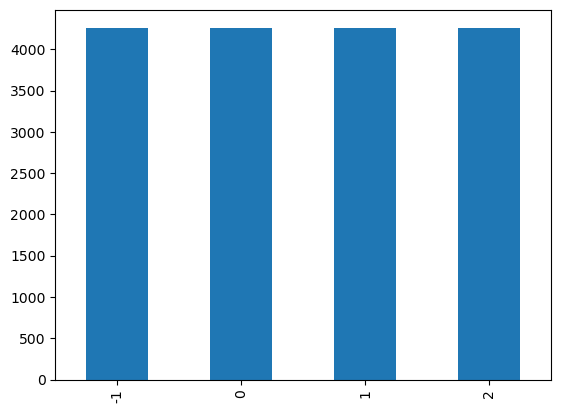

In [24]:
# resampled dataset 
new_df['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.show()

The new dataset contains the classes that are evenly distributed

# Feature Engineering on text data

Vectorization in classification is a process of converting preprocessed data to features in the form of numerical vectors for the machine learning algorithm to process the data. There are many techniques that can be used to vectorize the text into features but for this project, statistical features technique will be used.

In [25]:
def vectorize_data(train, test):
    
    vectorizer = TfidfVectorizer() # instantiate vectorizer object
    train_data = vectorizer.fit_transform(train) # fitting the train data
    test_data = vectorizer.transform(test) # fitting the test data
    
    return train_data, test_data, vectorizer

In [26]:
# vectorizing both the test and train dataset using the defined function
train_data, test_data, vectorizer = vectorize_data(new_df['message'], test_df['message'])

In [27]:
# check the shape of the dataset
train_data.shape, test_data.shape

((17060, 10157), (10546, 10157))

In [28]:
# print the first few features 
feature_names = vectorizer.get_feature_names_out()
feature_names.shape
for name in feature_names[80:90]:
    print(name)

accuse
accused
accuses
accusing
ace
acha
achievable
achieve
achieved
achieving


In [29]:
# Split the training data

y = new_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=42)

## Building Machine Learning Models

In this section different machine learning models will be trained and compered. The best performing model will be evaluated based on the f1 score, the high the f1 score the better the model perfomance.

models that will be trained include:
   - Logistic Regression Classifier
   - Support Vector Machines
   - RandomForestClassifier
   - DecisionTreeClassifier

### Logistic Regression Classifier

Logistic regression is a fundamental classification technique that belongs to the group of linear classifiers and is similar to polynomial and linear regression. Even though it is a method for binary classification, it can also be applied to multiclass problems by setting multiclass parameter to ovr.

In [30]:
# building logistic regression model

logreg = LogisticRegression(multi_class='ovr') # Define the model 
lr_run_time = %timeit -q -o logreg.fit(X_train, y_train) # fit the data
lr_pred = logreg.predict(X_test) # prediction
f1score_lr = f1_score(y_test, lr_pred, average= 'macro')
# print(classification_report(y_test, y_pred, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Ant']))

In [31]:
print(lr_run_time.best)
print(f1score_lr)

3.1565453000000048
0.7782020917552048


### Random Forest Classifier

Random forest is a supervised machine learning algorithm that is used widely in Classification and Regression problems. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression.

In [32]:
# random forest model
rf_model = RandomForestClassifier(max_depth=50, random_state=10) # Define the model 
rf_run_time = %timeit -q -o rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
f1score_rf = f1_score(y_test, rf_pred, average= 'macro')
# print(classification_report(y_test, rf_pred, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Ant']))

In [33]:
print(rf_run_time.best)
print(f1score_rf)

24.6582255
0.7710647768627621


### Decision Tree Classifier

Decision Tree is a supervised machine learning algorithm that uses a set of rules to make decisions. It builds a flowchart-like tree structure where each internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node (terminal node) holds a class label.

In [34]:
# decision tree classifier model

tree = DecisionTreeClassifier() # Define the model 
tree_run_time = %timeit -q -o tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
f1score_tree = f1_score(y_test, tree_pred, average= 'macro')
# print(classification_report(y_test, tree_pred, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Ant']))

In [35]:
print(tree_run_time.best)
print(f1score_tree)

5.2831621999999925
0.8139426587397934


### Support Vector Classifier

Support vector machines are capable of both linear and non-linear classification and can also be used for regression and anomaly/outlier detection. They work well for wide class of problems but are generally used for problems with small or medium sized data sets.

In [36]:
# grid_svm = svm.SVC(C = 1.0, gamma=2, kernel='rbf')
svm_model = svm.SVC()  # Define the model 
svm_run_time = %timeit -q -o svm_model.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)
f1score_svm = f1_score(y_test, svm_pred, average= 'macro')

In [37]:
print(svm_run_time.best)
print(f1score_svm)

80.06916449999994
0.8747236965046994


## Compare and choose the best model

In [59]:
# Create a dictionary for the model names and f1 scores
models = {'model_name' : ['Logistic Regression', 'Random Forest', 'Decision tree', 'svm_model'],
          'f1_score' : [f1score_lr, f1score_rf, f1score_tree ,f1score_svm,],
          'run_time': [lr_run_time.best, rf_run_time.best, tree_run_time.best, svm_run_time.best]
         }


model_comp_df = pd.DataFrame(models)    # Create a data frame from the dictionary

In [50]:
models = model_comp_df.set_index('model_name')
models

,f1_score,run_time
model_name,,
Logistic Regression,0.778202,3.156545
Random Forest,0.771065,24.658226
Decision tree,0.813943,5.283162
svm_model,0.889299,88.301825


<AxesSubplot:xlabel='model_name'>

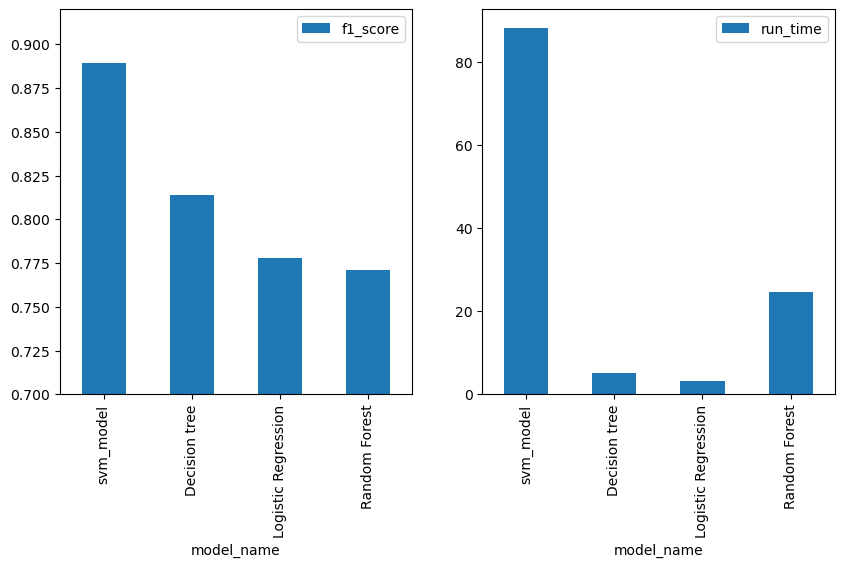

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
models.sort_values('f1_score', ascending=False, inplace=True)
models.plot(y=['f1_score'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.70,0.92])
models.plot(y='run_time', kind='bar', ax=ax[1])

Support Vector Model performed better than all the other models with the accuracy score of 87%. However, svm_model takes longer time to execute. SVM performed better with defualt parameters, and tunning the model would increase the accuracy score.

In [42]:
# dictionary of the parameters to search for to improve the ML model.
parameters = {'C': [0.001, 0.01, 0.1, 1, 10],
              'gamma': [0.001, 0.01, 0.1, 1],
             }

In [44]:
#GridsearchCV code below commented because it took long to execute

In [45]:
# searching for the best parameters to use in the ML model using GridSearchCV
# grid_svm = GridSearchCV(svm.SVC(kernel='rbf'), parameters, cv=3)
# grid_svm.fit(X_train,y_train)
# grid_svm.fit(train_data, new_df['sentiment'])

In [ ]:
# get the best parameters 
# grid_svm.best_params_           # {'C': 1.0, 'gamma': 2, 'kernel': 'rbf'}

In [ ]:
# svm_pred = grid_svm.predict(X_test)
# print(classification_report(y_test, svm_pred, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Ant']))

In [46]:
svm_model = svm.SVC(C=1.0, gamma=2, kernel='rbf')  # Define the model 
svm_run_time = %timeit -q -o svm_model.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)
f1score_svm = f1_score(y_test, svm_pred, average= 'macro')
print(classification_report(y_test, svm_pred, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Ant']))

              precision    recall  f1-score   support

     2: News       0.99      0.94      0.97       851
      1: Pro       0.94      0.87      0.90       861
  0: Neutral       0.76      0.87      0.81       876
     -1: Ant       0.89      0.87      0.88       824

    accuracy                           0.89      3412
   macro avg       0.89      0.89      0.89      3412
weighted avg       0.89      0.89      0.89      3412



With the best parameters obtained above, support vector classifier model performed even better with 89% accuracy score.

## Kaggle submission

In [52]:
y_pred = svm_model.predict(test_data)

In [53]:
submission = pd.DataFrame({'tweetid': test_df['tweetid'], 'sentiment':y_pred})
submission.to_csv('submission.csv', index=False)

In [54]:
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


## Saving a model with Pickle

In [55]:
model_save_path = "svc_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(svm_model,file)